In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
from leaf_att_forest import (
    GLAFParams,
    GammaLeafAttentionForest,
    ForestKind,
    TaskType,
)

In [3]:
n = 100
rng = np.random.RandomState(12345)

first_cov = np.array([
    [1.0, 0.5],
    [0.5, 1.0],
])
first_gaussian = rng.multivariate_normal(np.zeros(2), first_cov, size=n)

second_mean = np.array([0.1, 0.0])
second_cov = first_cov
second_gaussian = rng.multivariate_normal(second_mean, second_cov, size=n)

(-2.719921302291827,
 3.254631815729617,
 -3.6321430984597924,
 3.1408069663877276)

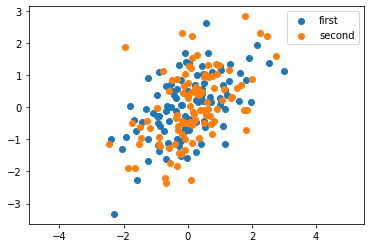

In [4]:
plt.scatter(first_gaussian[:, 0], first_gaussian[:, 1], label='first')
plt.scatter(second_gaussian[:, 0], second_gaussian[:, 1], label='second')
plt.legend()
plt.axis('equal')

In [5]:
first_y = first_gaussian.sum(axis=1) + rng.normal(0, 0.1, size=(n,))
second_y = second_gaussian.sum(axis=1) + rng.normal(0, 0.1, size=(n,))

X_first_train, X_first_test, y_first_train, y_first_test = train_test_split(
    first_gaussian, first_y,
    test_size=0.5,
    random_state=12345
)

X_second_train, X_second_test, y_second_train, y_second_test = train_test_split(
    second_gaussian, second_y,
    test_size=0.5,
    random_state=12345
)

X_all_train = np.concatenate((X_first_train, X_second_train), axis=0)
y_all_train = np.concatenate((y_first_train, y_second_train), axis=0)
X_all_test = np.concatenate((X_first_test, X_second_test), axis=0)
y_all_test = np.concatenate((y_first_test, y_second_test), axis=0)

In [6]:
model = GammaLeafAttentionForest(
    GLAFParams(
        kind=ForestKind.EXTRA,
        task=TaskType.REGRESSION,
        leaf_tau=1.0,
        leaf_attention=True,
        n_tau=35,
        fit_tree_weights=True,
        forest=dict(
            n_estimators=200,
            max_depth=None,
            min_samples_leaf=5,
            random_state=12345,
        ),
    )
)

In [7]:
model.fit(X_first_train, y_first_train)

In [8]:
model.optimize_weights(X_first_train, y_first_train)

In [9]:
results = {
    "Original (T=first) R2": r2_score(y_all_test, model.predict_original(X_all_test)),
    "Optimized (T=first, O=first) R2": r2_score(y_all_test, model.predict(X_all_test)),
}

In [10]:
model.optimize_weights(X_second_train, y_second_train)

In [11]:
results.update({
    "Optimized (T=first, O=second) R2": r2_score(y_all_test, model.predict(X_all_test)),
})

In [12]:
model.optimize_weights(X_all_train, y_all_train)

In [13]:
results.update({
    "Optimized (T=first, O=first+second) R2": r2_score(y_all_test, model.predict(X_all_test)),
})

In [14]:
model.fit(X_all_train, y_all_train)

In [15]:
results.update({
    "Original (T=first+second) R2": r2_score(y_all_test, model.predict_original(X_all_test)),
})

In [16]:
model.optimize_weights(X_all_train, y_all_train)

In [17]:
results.update({
    "Optimized (T,O=first+second) R2": r2_score(y_all_test, model.predict(X_all_test)),
})

In [18]:
print("T = dataset for tree fit;")
print("O = dataset for weights optimization;")
print('=' * 50)
print('\n'.join(map(lambda x: f'{x[0]:>40}: {x[1]:.3f}', results.items())))

T = dataset for tree fit;
O = dataset for weights optimization;
                   Original (T=first) R2: 0.658
         Optimized (T=first, O=first) R2: 0.961
        Optimized (T=first, O=second) R2: 0.972
  Optimized (T=first, O=first+second) R2: 0.974
            Original (T=first+second) R2: 0.886
         Optimized (T,O=first+second) R2: 0.990
